<a href="https://colab.research.google.com/github/mdaffaalghiffari23/KomputasiIntelegensia/blob/main/TaskWeek2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Muhammad Daffa Alghiffari

NPM: 2106726075

In [1]:
!pip install d2l


# Multilayer Perceptrons
:label:`sec_mlp`

In :numref:`sec_softmax`, we introduced
softmax regression,
implementing the algorithm from scratch
(:numref:`sec_softmax_scratch`) and using high-level APIs
(:numref:`sec_softmax_concise`). This allowed us to
train classifiers capable of recognizing
10 categories of clothing from low-resolution images.
Along the way, we learned how to wrangle data,
coerce our outputs into a valid probability distribution,
apply an appropriate loss function,
and minimize it with respect to our model's parameters.
Now that we have mastered these mechanics
in the context of simple linear models,
we can launch our exploration of deep neural networks,
the comparatively rich class of models
with which this book is primarily concerned.


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Hidden Layers

We described affine transformations in
:numref:`subsec_linear_model` as
linear transformations with added bias.
To begin, recall the model architecture
corresponding to our softmax regression example,
illustrated in  :numref:`fig_softmaxreg`.
This model maps inputs directly to outputs
via a single affine transformation,
followed by a softmax operation.
If our labels truly were related
to the input data by a simple affine transformation,
then this approach would be sufficient.
However, linearity (in affine transformations) is a *strong* assumption.

### Limitations of Linear Models

For example, linearity implies the *weaker*
assumption of *monotonicity*, i.e.,
that any increase in our feature must
either always cause an increase in our model's output
(if the corresponding weight is positive),
or always cause a decrease in our model's output
(if the corresponding weight is negative).
Sometimes that makes sense.
For example, if we were trying to predict
whether an individual will repay a loan,
we might reasonably assume that all other things being equal,
an applicant with a higher income
would always be more likely to repay
than one with a lower income.
While monotonic, this relationship likely
is not linearly associated with the probability of
repayment. An increase in income from \$0 to \$50,000
likely corresponds to a bigger increase
in likelihood of repayment
than an increase from \$1 million to \$1.05 million.
One way to handle this might be to postprocess our outcome
such that linearity becomes more plausible,
by using the logistic map (and thus the logarithm of the probability of outcome).

Note that we can easily come up with examples
that violate monotonicity.
Say for example that we want to predict health as a function
of body temperature.
For individuals with a normal body temperature
above 37°C (98.6°F),
higher temperatures indicate greater risk.
However, if the body temperatures drops
below 37°C, lower temperatures indicate greater risk!
Again, we might resolve the problem
with some clever preprocessing, such as using the distance from 37°C
as a feature.


But what about classifying images of cats and dogs?
Should increasing the intensity
of the pixel at location (13, 17)
always increase (or always decrease)
the likelihood that the image depicts a dog?
Reliance on a linear model corresponds to the implicit
assumption that the only requirement
for differentiating cats and dogs is to assess
the brightness of individual pixels.
This approach is doomed to fail in a world
where inverting an image preserves the category.

And yet despite the apparent absurdity of linearity here,
as compared with our previous examples,
it is less obvious that we could address the problem
with a simple preprocessing fix.
That is, because the significance of any pixel
depends in complex ways on its context
(the values of the surrounding pixels).
While there might exist a representation of our data
that would take into account
the relevant interactions among our features,
on top of which a linear model would be suitable,
we simply do not know how to calculate it by hand.
With deep neural networks, we used observational data
to jointly learn both a representation via hidden layers
and a linear predictor that acts upon that representation.

This problem of nonlinearity has been studied for at least a
century :cite:`Fisher.1928`. For instance, decision trees
in their most basic form use a sequence of binary decisions to
decide upon class membership :cite:`quinlan2014c4`. Likewise, kernel
methods have been used for many decades to model nonlinear dependencies
:cite:`Aronszajn.1950`. This has found its way into
nonparametric spline models :cite:`Wahba.1990` and kernel methods
:cite:`Scholkopf.Smola.2002`. It is also something that the brain solves
quite naturally. After all, neurons feed into other neurons which,
in turn, feed into other neurons again :cite:`Cajal.Azoulay.1894`.
Consequently we have a sequence of relatively simple transformations.

### Incorporating Hidden Layers

We can overcome the limitations of linear models
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many fully connected layers on top of one another.
Each layer feeds into the layer above it,
until we generate outputs.
We can think of the first $L-1$ layers
as our representation and the final layer
as our linear predictor.
This architecture is commonly called
a *multilayer perceptron*,
often abbreviated as *MLP* (:numref:`fig_mlp`).

![An MLP with a hidden layer of five hidden units.](http://d2l.ai/_images/mlp.svg)
:label:`fig_mlp`

This MLP has four inputs, three outputs,
and its hidden layer contains five hidden units.
Since the input layer does not involve any calculations,
producing outputs with this network
requires implementing the computations
for both the hidden and output layers;
thus, the number of layers in this MLP is two.
Note that both layers are fully connected.
Every input influences every neuron in the hidden layer,
and each of these in turn influences
every neuron in the output layer. Alas, we are not quite
done yet.

### From Linear to Nonlinear

As before, we denote by the matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$
a minibatch of $n$ examples where each example has $d$ inputs (features).
For a one-hidden-layer MLP whose hidden layer has $h$ hidden units,
we denote by $\mathbf{H} \in \mathbb{R}^{n \times h}$
the outputs of the hidden layer, which are
*hidden representations*.
Since the hidden and output layers are both fully connected,
we have hidden-layer weights $\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$ and biases $\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
and output-layer weights $\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$ and biases $\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$.
This allows us to calculate the outputs $\mathbf{O} \in \mathbb{R}^{n \times q}$
of the one-hidden-layer MLP as follows:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

Note that after adding the hidden layer,
our model now requires us to track and update
additional sets of parameters.
So what have we gained in exchange?
You might be surprised to find out
that---in the model defined above---*we
gain nothing for our troubles*!
The reason is plain.
The hidden units above are given by
an affine function of the inputs,
and the outputs (pre-softmax) are just
an affine function of the hidden units.
An affine function of an affine function
is itself an affine function.
Moreover, our linear model was already
capable of representing any affine function.

To see this formally we can just collapse out the hidden layer in the above definition,
yielding an equivalent single-layer model with parameters
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

In order to realize the potential of multilayer architectures,
we need one more key ingredient: a
nonlinear *activation function* $\sigma$
to be applied to each hidden unit
following the affine transformation. For instance, a popular
choice is the ReLU (rectified linear unit) activation function :cite:`Nair.Hinton.2010`
$\sigma(x) = \mathrm{max}(0, x)$ operating on its arguments elementwise.
The outputs of activation functions $\sigma(\cdot)$
are called *activations*.
In general, with activation functions in place,
it is no longer possible to collapse our MLP into a linear model:

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

Since each row in $\mathbf{X}$ corresponds to an example in the minibatch,
with some abuse of notation, we define the nonlinearity
$\sigma$ to apply to its inputs in a rowwise fashion,
i.e., one example at a time.
Note that we used the same notation for softmax
when we denoted a rowwise operation in :numref:`subsec_softmax_vectorization`.
Quite frequently the activation functions we use apply not merely rowwise but
elementwise. That means that after computing the linear portion of the layer,
we can calculate each activation
without looking at the values taken by the other hidden units.

To build more general MLPs, we can continue stacking
such hidden layers,
e.g., $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
and $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$,
one atop another, yielding ever more expressive models.

### Universal Approximators

We know that the brain is capable of very sophisticated statistical analysis. As such,
it is worth asking, just *how powerful* a deep network could be. This question
has been answered multiple times, e.g., in :citet:`Cybenko.1989` in the context
of MLPs, and in :citet:`micchelli1984interpolation` in the context of reproducing kernel
Hilbert spaces in a way that could be seen as radial basis function (RBF) networks with a single hidden layer.
These (and related results) suggest that even with a single-hidden-layer network,
given enough nodes (possibly absurdly many),
and the right set of weights,
we can model any function.
Actually learning that function is the hard part, though.
You might think of your neural network
as being a bit like the C programming language.
The language, like any other modern language,
is capable of expressing any computable program.
But actually coming up with a program
that meets your specifications is the hard part.

Moreover, just because a single-hidden-layer network
*can* learn any function
does not mean that you should try
to solve all of your problems
with one. In fact, in this case kernel methods
are way more effective, since they are capable of solving the problem
*exactly* even in infinite dimensional spaces :cite:`Kimeldorf.Wahba.1971,Scholkopf.Herbrich.Smola.2001`.
In fact, we can approximate many functions
much more compactly by using deeper (rather than wider) networks :cite:`Simonyan.Zisserman.2014`.
We will touch upon more rigorous arguments in subsequent chapters.


## Activation Functions
:label:`subsec_activation-functions`

Activation functions decide whether a neuron should be activated or not by
calculating the weighted sum and further adding bias to it.
They are differentiable operators for transforming input signals to outputs,
while most of them add nonlinearity.
Because activation functions are fundamental to deep learning,
(**let's briefly survey some common ones**).

### ReLU Function

The most popular choice,
due to both simplicity of implementation and
its good performance on a variety of predictive tasks,
is the *rectified linear unit* (*ReLU*) :cite:`Nair.Hinton.2010`.
[**ReLU provides a very simple nonlinear transformation**].
Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements
by setting the corresponding activations to 0.
To gain some intuition, we can plot the function.
As you can see, the activation function is piecewise linear.


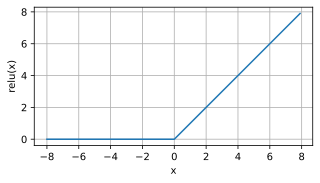

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

When the input is negative,
the derivative of the ReLU function is 0,
and when the input is positive,
the derivative of the ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to 0.
In these cases, we default to the left-hand-side
derivative and say that the derivative is 0 when the input is 0.
We can get away with this because
the input may never actually be zero (mathematicians would
say that it is nondifferentiable on a set of measure zero).
There is an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here, or at least, the fact that
we are not performing constrained optimization :cite:`Mangasarian.1965,Rockafellar.1970`.
We plot the derivative of the ReLU function below.


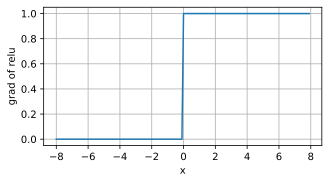

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

The reason for using ReLU is that
its derivatives are particularly well behaved:
either they vanish or they just let the argument through.
This makes optimization better behaved
and it mitigated the well-documented problem
of vanishing gradients that plagued
previous versions of neural networks (more on this later).

Note that there are many variants to the ReLU function,
including the *parametrized ReLU* (*pReLU*) function :cite:`He.Zhang.Ren.ea.2015`.
This variation adds a linear term to ReLU,
so some information still gets through,
even when the argument is negative:

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Sigmoid Function

[**The *sigmoid function* transforms those inputs**]
whose values lie in the domain $\mathbb{R}$,
(**to outputs that lie on the interval (0, 1).**)
For that reason, the sigmoid is
often called a *squashing function*:
it squashes any input in the range (-inf, inf)
to some value in the range (0, 1):

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
that either *fire* or *do not fire*.
Thus the pioneers of this field,
going all the way back to McCulloch and Pitts,
the inventors of the artificial neuron,
focused on thresholding units :cite:`McCulloch.Pitts.1943`.
A thresholding activation takes value 0
when its input is below some threshold
and value 1 when the input exceeds the threshold.

When attention shifted to gradient-based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable
approximation to a thresholding unit.
Sigmoids are still widely used as
activation functions on the output units
when we want to interpret the outputs as probabilities
for binary classification problems: you can think of the sigmoid as a special case of the softmax.
However, the sigmoid has largely been replaced
by the simpler and more easily trainable ReLU
for most use in hidden layers. Much of this has to do
with the fact that the sigmoid poses challenges for optimization
:cite:`LeCun.Bottou.Orr.ea.1998` since its gradient vanishes for large positive *and* negative arguments.
This can lead to plateaus that are difficult to escape from.
Nonetheless sigmoids are important. In later chapters (e.g., :numref:`sec_lstm`) on recurrent neural networks,
we will describe architectures that leverage sigmoid units
to control the flow of information across time.

Below, we plot the sigmoid function.
Note that when the input is close to 0,
the sigmoid function approaches
a linear transformation.


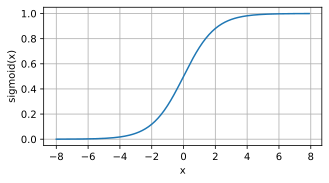

In [ ]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

The derivative of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


The derivative of the sigmoid function is plotted below.
Note that when the input is 0,
the derivative of the sigmoid function
reaches a maximum of 0.25.
As the input diverges from 0 in either direction,
the derivative approaches 0.


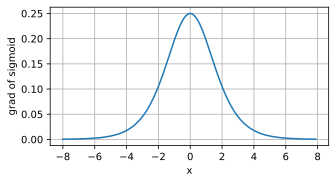

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### Tanh Function
:label:`subsec_tanh`

Like the sigmoid function, [**the tanh (hyperbolic tangent)
function also squashes its inputs**],
transforming them into elements on the interval (**between $-1$ and $1$**):

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function below. Note that as input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system :cite:`Kalman.Kwasny.1992`.


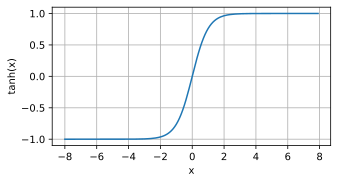

In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

The derivative of the tanh function is:

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

It is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.


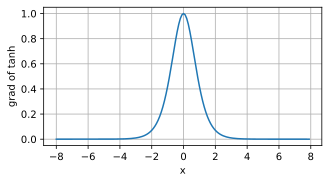

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## Summary and Discussion

We now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge already
puts you in command of a similar toolkit
to a practitioner circa 1990.
In some ways, you have an advantage
over anyone working back then,
because you can leverage powerful
open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, training these networks
required researchers to code up layers and derivatives
explicitly in C, Fortran, or even Lisp (in the case of LeNet).

A secondary benefit is that ReLU is significantly more amenable to
optimization than the sigmoid or the tanh function. One could argue
that this was one of the key innovations that helped the resurgence
of deep learning over the past decade. Note, though, that research in
activation functions has not stopped.
For instance,
the GELU (Gaussian error linear unit)
activation function $x \Phi(x)$ by :citet:`Hendrycks.Gimpel.2016` ($\Phi(x)$
is the standard Gaussian cumulative distribution function)
and
the Swish activation
function $\sigma(x) = x \operatorname{sigmoid}(\beta x)$ as proposed in :citet:`Ramachandran.Zoph.Le.2017` can yield better accuracy
in many cases.

## Exercises

1. Show that adding layers to a *linear* deep network, i.e., a network without
   nonlinearity $\sigma$ can never increase the expressive power of the network.
   Give an example where it actively reduces it.
1. Compute the derivative of the pReLU activation function.
1. Compute the derivative of the Swish activation function $x \operatorname{sigmoid}(\beta x)$.
1. Show that an MLP using only ReLU (or pReLU) constructs a
   continuous piecewise linear function.
1. Sigmoid and tanh are very similar.
    1. Show that $\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$.
    1. Prove that the function classes parametrized by both nonlinearities are identical. Hint: affine layers have bias terms, too.
1. Assume that we have a nonlinearity that applies to one minibatch at a time, such as the batch normalization :cite:`Ioffe.Szegedy.2015`. What kinds of problems do you expect this to cause?
1. Provide an example where the gradients vanish for the sigmoid activation function.


[Discussions](https://discuss.d2l.ai/t/91)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use `nn.Parameter`
to automatically register
a class attribute as a parameter to be tracked by `autograd` (:numref:`sec_autograd`).


In [ ]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

To make sure we know how everything works,
we will [**implement the ReLU activation**] ourselves
rather than invoking the built-in `relu` function directly.


In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

Since we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we (**implement our model**)
with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.


In [ ]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.


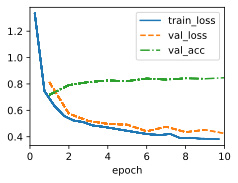

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [ ]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


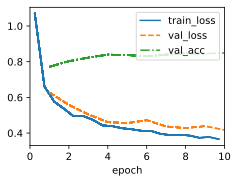

In [ ]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor--matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?


[Discussions](https://discuss.d2l.ai/t/93)


# Forward Propagation, Backward Propagation, and Computational Graphs
:label:`sec_backprop`

So far, we have trained our models
with minibatch stochastic gradient descent.
However, when we implemented the algorithm,
we only worried about the calculations involved
in *forward propagation* through the model.
When it came time to calculate the gradients,
we just invoked the backpropagation function provided by the deep learning framework.

The automatic calculation of gradients
profoundly simplifies
the implementation of deep learning algorithms.
Before automatic differentiation,
even small changes to complicated models required
recalculating complicated derivatives by hand.
Surprisingly often, academic papers had to allocate
numerous pages to deriving update rules.
While we must continue to rely on automatic differentiation
so we can focus on the interesting parts,
you ought to know how these gradients
are calculated under the hood
if you want to go beyond a shallow
understanding of deep learning.

In this section, we take a deep dive
into the details of *backward propagation*
(more commonly called *backpropagation*).
To convey some insight for both the
techniques and their implementations,
we rely on some basic mathematics and computational graphs.
To start, we focus our exposition on
a one-hidden-layer MLP
with weight decay ($\ell_2$ regularization, to be described in subsequent chapters).

## Forward Propagation

*Forward propagation* (or *forward pass*) refers to the calculation and storage
of intermediate variables (including outputs)
for a neural network in order
from the input layer to the output layer.
We now work step-by-step through the mechanics
of a neural network with one hidden layer.
This may seem tedious but in the eternal words
of funk virtuoso James Brown,
you must "pay the cost to be the boss".


For the sake of simplicity, let's assume
that the input example is $\mathbf{x}\in \mathbb{R}^d$
and that our hidden layer does not include a bias term.
Here the intermediate variable is:

$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x},$$

where $\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
is the weight parameter of the hidden layer.
After running the intermediate variable
$\mathbf{z}\in \mathbb{R}^h$ through the
activation function $\phi$
we obtain our hidden activation vector of length $h$:

$$\mathbf{h}= \phi (\mathbf{z}).$$

The hidden layer output $\mathbf{h}$
is also an intermediate variable.
Assuming that the parameters of the output layer
possess only a weight of
$\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$,
we can obtain an output layer variable
with a vector of length $q$:

$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

Assuming that the loss function is $l$
and the example label is $y$,
we can then calculate the loss term
for a single data example,

$$L = l(\mathbf{o}, y).$$

As we will see the definition of $\ell_2$ regularization
to be introduced later,
given the hyperparameter $\lambda$,
the regularization term is

$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_\textrm{F}^2 + \|\mathbf{W}^{(2)}\|_\textrm{F}^2\right),$$
:eqlabel:`eq_forward-s`

where the Frobenius norm of the matrix
is simply the $\ell_2$ norm applied
after flattening the matrix into a vector.
Finally, the model's regularized loss
on a given data example is:

$$J = L + s.$$

We refer to $J$ as the *objective function*
in the following discussion.


## Computational Graph of Forward Propagation

Plotting *computational graphs* helps us visualize
the dependencies of operators
and variables within the calculation.
:numref:`fig_forward` contains the graph associated
with the simple network described above,
where squares denote variables and circles denote operators.
The lower-left corner signifies the input
and the upper-right corner is the output.
Notice that the directions of the arrows
(which illustrate data flow)
are primarily rightward and upward.

![Computational graph of forward propagation.](http://d2l.ai/_images/forward.svg)
:label:`fig_forward`

## Backpropagation

*Backpropagation* refers to the method of calculating
the gradient of neural network parameters.
In short, the method traverses the network in reverse order,
from the output to the input layer,
according to the *chain rule* from calculus.
The algorithm stores any intermediate variables
(partial derivatives)
required while calculating the gradient
with respect to some parameters.
Assume that we have functions
$\mathsf{Y}=f(\mathsf{X})$
and $\mathsf{Z}=g(\mathsf{Y})$,
in which the input and the output
$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$
are tensors of arbitrary shapes.
By using the chain rule,
we can compute the derivative
of $\mathsf{Z}$ with respect to $\mathsf{X}$ via

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \textrm{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

Here we use the $\textrm{prod}$ operator
to multiply its arguments
after the necessary operations,
such as transposition and swapping input positions,
have been carried out.
For vectors, this is straightforward:
it is simply matrix--matrix multiplication.
For higher dimensional tensors,
we use the appropriate counterpart.
The operator $\textrm{prod}$ hides all the notational overhead.

Recall that
the parameters of the simple network with one hidden layer,
whose computational graph is in :numref:`fig_forward`,
are $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$.
The objective of backpropagation is to
calculate the gradients $\partial J/\partial \mathbf{W}^{(1)}$
and $\partial J/\partial \mathbf{W}^{(2)}$.
To accomplish this, we apply the chain rule
and calculate, in turn, the gradient of
each intermediate variable and parameter.
The order of calculations are reversed
relative to those performed in forward propagation,
since we need to start with the outcome of the computational graph
and work our way towards the parameters.
The first step is to calculate the gradients
of the objective function $J=L+s$
with respect to the loss term $L$
and the regularization term $s$:

$$\frac{\partial J}{\partial L} = 1 \; \textrm{and} \; \frac{\partial J}{\partial s} = 1.$$

Next, we compute the gradient of the objective function
with respect to variable of the output layer $\mathbf{o}$
according to the chain rule:

$$
\frac{\partial J}{\partial \mathbf{o}}
= \textrm{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q.
$$

Next, we calculate the gradients
of the regularization term
with respect to both parameters:

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\; \textrm{and} \;
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$

Now we are able to calculate the gradient
$\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$
of the model parameters closest to the output layer.
Using the chain rule yields:

$$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \textrm{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.$$
:eqlabel:`eq_backprop-J-h`

To obtain the gradient with respect to $\mathbf{W}^{(1)}$
we need to continue backpropagation
along the output layer to the hidden layer.
The gradient with respect to the hidden layer output
$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$ is given by


$$
\frac{\partial J}{\partial \mathbf{h}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$

Since the activation function $\phi$ applies elementwise,
calculating the gradient $\partial J/\partial \mathbf{z} \in \mathbb{R}^h$
of the intermediate variable $\mathbf{z}$
requires that we use the elementwise multiplication operator,
which we denote by $\odot$:

$$
\frac{\partial J}{\partial \mathbf{z}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$

Finally, we can obtain the gradient
$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
of the model parameters closest to the input layer.
According to the chain rule, we get

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \textrm{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \textrm{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$



## Training Neural Networks

When training neural networks,
forward and backward propagation depend on each other.
In particular, for forward propagation,
we traverse the computational graph in the direction of dependencies
and compute all the variables on its path.
These are then used for backpropagation
where the compute order on the graph is reversed.

Take the aforementioned simple network as an illustrative example.
On the one hand,
computing the regularization term :eqref:`eq_forward-s`
during forward propagation
depends on the current values of model parameters $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$.
They are given by the optimization algorithm according to backpropagation in the most recent iteration.
On the other hand,
the gradient calculation for the parameter
:eqref:`eq_backprop-J-h` during backpropagation
depends on the current value of the hidden layer output $\mathbf{h}$,
which is given by forward propagation.


Therefore when training neural networks, once model parameters are initialized,
we alternate forward propagation with backpropagation,
updating model parameters using gradients given by backpropagation.
Note that backpropagation reuses the stored intermediate values from forward propagation to avoid duplicate calculations.
One of the consequences is that we need to retain
the intermediate values until backpropagation is complete.
This is also one of the reasons why training
requires significantly more memory than plain prediction.
Besides, the size of such intermediate values is roughly
proportional to the number of network layers and the batch size.
Thus,
training deeper networks using larger batch sizes
more easily leads to *out-of-memory* errors.


## Summary

Forward propagation sequentially calculates and stores intermediate variables within the computational graph defined by the neural network. It proceeds from the input to the output layer.
Backpropagation sequentially calculates and stores the gradients of intermediate variables and parameters within the neural network in the reversed order.
When training deep learning models, forward propagation and backpropagation are interdependent,
and training requires significantly more memory than prediction.


## Exercises

1. Assume that the inputs $\mathbf{X}$ to some scalar function $f$ are $n \times m$ matrices. What is the dimensionality of the gradient of $f$ with respect to $\mathbf{X}$?
1. Add a bias to the hidden layer of the model described in this section (you do not need to include bias in the regularization term).
    1. Draw the corresponding computational graph.
    1. Derive the forward and backward propagation equations.
1. Compute the memory footprint for training and prediction in the model described in this section.
1. Assume that you want to compute second derivatives. What happens to the computational graph? How long do you expect the calculation to take?
1. Assume that the computational graph is too large for your GPU.
    1. Can you partition it over more than one GPU?
    1. What are the advantages and disadvantages over training on a smaller minibatch?

[Discussions](https://discuss.d2l.ai/t/102)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

# Numerical Stability and Initialization
:label:`sec_numerical_stability`


Thus far, every model that we have implemented
required that we initialize its parameters
according to some pre-specified distribution.
Until now, we took the initialization scheme for granted,
glossing over the details of how these choices are made.
You might have even gotten the impression that these choices
are not especially important.
On the contrary, the choice of initialization scheme
plays a significant role in neural network learning,
and it can be crucial for maintaining numerical stability.
Moreover, these choices can be tied up in interesting ways
with the choice of the nonlinear activation function.
Which function we choose and how we initialize parameters
can determine how quickly our optimization algorithm converges.
Poor choices here can cause us to encounter
exploding or vanishing gradients while training.
In this section, we delve into these topics in greater detail
and discuss some useful heuristics
that you will find useful
throughout your career in deep learning.


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

## Vanishing and Exploding Gradients

Consider a deep network with $L$ layers,
input $\mathbf{x}$ and output $\mathbf{o}$.
With each layer $l$ defined by a transformation $f_l$
parametrized by weights $\mathbf{W}^{(l)}$,
whose hidden layer output is $\mathbf{h}^{(l)}$ (let $\mathbf{h}^{(0)} = \mathbf{x}$),
our network can be expressed as:

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \textrm{ and thus } \mathbf{o} = f_L \circ \cdots \circ f_1(\mathbf{x}).$$

If all the hidden layer output and the input are vectors,
we can write the gradient of $\mathbf{o}$ with respect to
any set of parameters $\mathbf{W}^{(l)}$ as follows:

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\textrm{def}}{=}} \cdots \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\textrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\textrm{def}}{=}}.$$

In other words, this gradient is
the product of $L-l$ matrices
$\mathbf{M}^{(L)} \cdots \mathbf{M}^{(l+1)}$
and the gradient vector $\mathbf{v}^{(l)}$.
Thus we are susceptible to the same
problems of numerical underflow that often crop up
when multiplying together too many probabilities.
When dealing with probabilities, a common trick is to
switch into log-space, i.e., shifting
pressure from the mantissa to the exponent
of the numerical representation.
Unfortunately, our problem above is more serious:
initially the matrices $\mathbf{M}^{(l)}$ may have a wide variety of eigenvalues.
They might be small or large, and
their product might be *very large* or *very small*.

The risks posed by unstable gradients
go beyond numerical representation.
Gradients of unpredictable magnitude
also threaten the stability of our optimization algorithms.
We may be facing parameter updates that are either
(i) excessively large, destroying our model
(the *exploding gradient* problem);
or (ii) excessively small
(the *vanishing gradient* problem),
rendering learning impossible as parameters
hardly move on each update.


### (**Vanishing Gradients**)

One frequent culprit causing the vanishing gradient problem
is the choice of the activation function $\sigma$
that is appended following each layer's linear operations.
Historically, the sigmoid function
$1/(1 + \exp(-x))$ (introduced in :numref:`sec_mlp`)
was popular because it resembles a thresholding function.
Since early artificial neural networks were inspired
by biological neural networks,
the idea of neurons that fire either *fully* or *not at all*
(like biological neurons) seemed appealing.
Let's take a closer look at the sigmoid
to see why it can cause vanishing gradients.


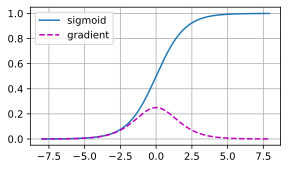

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

As you can see, (**the sigmoid's gradient vanishes
both when its inputs are large and when they are small**).
Moreover, when backpropagating through many layers,
unless we are in the Goldilocks zone, where
the inputs to many of the sigmoids are close to zero,
the gradients of the overall product may vanish.
When our network boasts many layers,
unless we are careful, the gradient
will likely be cut off at some layer.
Indeed, this problem used to plague deep network training.
Consequently, ReLUs, which are more stable
(but less neurally plausible),
have emerged as the default choice for practitioners.


### [**Exploding Gradients**]

The opposite problem, when gradients explode,
can be similarly vexing.
To illustrate this a bit better,
we draw 100 Gaussian random matrices
and multiply them with some initial matrix.
For the scale that we picked
(the choice of the variance $\sigma^2=1$),
the matrix product explodes.
When this happens because of the initialization
of a deep network, we have no chance of getting
a gradient descent optimizer to converge.


In [ ]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-0.1540, -0.0207, -0.8019,  0.7721],
        [-0.4799, -0.2961,  0.1809,  0.3742],
        [-0.9772,  0.3902,  1.8449, -0.3007],
        [ 0.8004, -0.2607,  1.2065, -1.0769]])
after multiplying 100 matrices
 tensor([[-2.5776e+19, -2.1695e+21, -6.3642e+20,  2.5017e+21],
        [ 2.1732e+19,  1.8778e+21,  5.4976e+20, -2.1624e+21],
        [ 1.1852e+20,  1.0039e+22,  2.9436e+21, -1.1572e+22],
        [ 1.4751e+19,  1.2198e+21,  3.5831e+20, -1.4078e+21]])


### Breaking the Symmetry

Another problem in neural network design
is the symmetry inherent in their parametrization.
Assume that we have a simple MLP
with one hidden layer and two units.
In this case, we could permute the weights $\mathbf{W}^{(1)}$
of the first layer and likewise permute
the weights of the output layer
to obtain the same function.
There is nothing special differentiating
the first and second hidden units.
In other words, we have permutation symmetry
among the hidden units of each layer.

This is more than just a theoretical nuisance.
Consider the aforementioned one-hidden-layer MLP
with two hidden units.
For illustration,
suppose that the output layer transforms the two hidden units into only one output unit.
Imagine what would happen if we initialized
all the parameters of the hidden layer
as $\mathbf{W}^{(1)} = c$ for some constant $c$.
In this case, during forward propagation
either hidden unit takes the same inputs and parameters
producing the same activation
which is fed to the output unit.
During backpropagation,
differentiating the output unit with respect to parameters $\mathbf{W}^{(1)}$ gives a gradient all of whose elements take the same value.
Thus, after gradient-based iteration (e.g., minibatch stochastic gradient descent),
all the elements of $\mathbf{W}^{(1)}$ still take the same value.
Such iterations would
never *break the symmetry* on their own
and we might never be able to realize
the network's expressive power.
The hidden layer would behave
as if it had only a single unit.
Note that while minibatch stochastic gradient descent would not break this symmetry,
dropout regularization (to be introduced later) would!


## Parameter Initialization

One way of addressing---or at least mitigating---the
issues raised above is through careful initialization.
As we will see later,
additional care during optimization
and suitable regularization can further enhance stability.


### Default Initialization

In the previous sections, e.g., in :numref:`sec_linear_concise`,
we used a normal distribution
to initialize the values of our weights.
If we do not specify the initialization method, the framework will
use a default random initialization method, which often works well in practice
for moderate problem sizes.






### Xavier Initialization
:label:`subsec_xavier`

Let's look at the scale distribution of
an output $o_{i}$ for some fully connected layer
*without nonlinearities*.
With $n_\textrm{in}$ inputs $x_j$
and their associated weights $w_{ij}$ for this layer,
an output is given by

$$o_{i} = \sum_{j=1}^{n_\textrm{in}} w_{ij} x_j.$$

The weights $w_{ij}$ are all drawn
independently from the same distribution.
Furthermore, let's assume that this distribution
has zero mean and variance $\sigma^2$.
Note that this does not mean that the distribution has to be Gaussian,
just that the mean and variance need to exist.
For now, let's assume that the inputs to the layer $x_j$
also have zero mean and variance $\gamma^2$
and that they are independent of $w_{ij}$ and independent of each other.
In this case, we can compute the mean of $o_i$:

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\textrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\textrm{in}} E[w_{ij}] E[x_j] \\&= 0, \end{aligned}$$

and the variance:

$$
\begin{aligned}
    \textrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\textrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\textrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

One way to keep the variance fixed
is to set $n_\textrm{in} \sigma^2 = 1$.
Now consider backpropagation.
There we face a similar problem,
albeit with gradients being propagated from the layers closer to the output.
Using the same reasoning as for forward propagation,
we see that the gradients' variance can blow up
unless $n_\textrm{out} \sigma^2 = 1$,
where $n_\textrm{out}$ is the number of outputs of this layer.
This leaves us in a dilemma:
we cannot possibly satisfy both conditions simultaneously.
Instead, we simply try to satisfy:

$$
\begin{aligned}
\frac{1}{2} (n_\textrm{in} + n_\textrm{out}) \sigma^2 = 1 \textrm{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\textrm{in} + n_\textrm{out}}}.
\end{aligned}
$$

This is the reasoning underlying the now-standard
and practically beneficial *Xavier initialization*,
named after the first author of its creators :cite:`Glorot.Bengio.2010`.
Typically, the Xavier initialization
samples weights from a Gaussian distribution
with zero mean and variance
$\sigma^2 = \frac{2}{n_\textrm{in} + n_\textrm{out}}$.
We can also adapt this to
choose the variance when sampling weights
from a uniform distribution.
Note that the uniform distribution $U(-a, a)$ has variance $\frac{a^2}{3}$.
Plugging $\frac{a^2}{3}$ into our condition on $\sigma^2$
prompts us to initialize according to

$$U\left(-\sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}, \sqrt{\frac{6}{n_\textrm{in} + n_\textrm{out}}}\right).$$

Though the assumption for nonexistence of nonlinearities
in the above mathematical reasoning
can be easily violated in neural networks,
the Xavier initialization method
turns out to work well in practice.


### Beyond

The reasoning above barely scratches the surface
of modern approaches to parameter initialization.
A deep learning framework often implements over a dozen different heuristics.
Moreover, parameter initialization continues to be
a hot area of fundamental research in deep learning.
Among these are heuristics specialized for
tied (shared) parameters, super-resolution,
sequence models, and other situations.
For instance,
:citet:`Xiao.Bahri.Sohl-Dickstein.ea.2018` demonstrated the possibility of training
10,000-layer neural networks without architectural tricks
by using a carefully-designed initialization method.

If the topic interests you we suggest
a deep dive into this module's offerings,
reading the papers that proposed and analyzed each heuristic,
and then exploring the latest publications on the topic.
Perhaps you will stumble across or even invent
a clever idea and contribute an implementation to deep learning frameworks.


## Summary

Vanishing and exploding gradients are common issues in deep networks. Great care in parameter initialization is required to ensure that gradients and parameters remain well controlled.
Initialization heuristics are needed to ensure that the initial gradients are neither too large nor too small.
Random initialization is key to ensuring that symmetry is broken before optimization.
Xavier initialization suggests that, for each layer, variance of any output is not affected by the number of inputs, and variance of any gradient is not affected by the number of outputs.
ReLU activation functions mitigate the vanishing gradient problem. This can accelerate convergence.

## Exercises

1. Can you design other cases where a neural network might exhibit symmetry that needs breaking, besides the permutation symmetry in an MLP's layers?
1. Can we initialize all weight parameters in linear regression or in softmax regression to the same value?
1. Look up analytic bounds on the eigenvalues of the product of two matrices. What does this tell you about ensuring that gradients are well conditioned?
1. If we know that some terms diverge, can we fix this after the fact? Look at the paper on layerwise adaptive rate scaling  for inspiration :cite:`You.Gitman.Ginsburg.2017`.


[Discussions](https://discuss.d2l.ai/t/104)


# Generalization in Deep Learning


In :numref:`chap_regression` and :numref:`chap_classification`,
we tackled regression and classification problems
by fitting linear models to training data.
In both cases, we provided practical algorithms
for finding the parameters that maximized
the likelihood of the observed training labels.
And then, towards the end of each chapter,
we recalled that fitting the training data
was only an intermediate goal.
Our real quest all along was to discover *general patterns*
on the basis of which we can make accurate predictions
even on new examples drawn from the same underlying population.
Machine learning researchers are *consumers* of optimization algorithms.
Sometimes, we must even develop new optimization algorithms.
But at the end of the day, optimization is merely a means to an end.
At its core, machine learning is a statistical discipline
and we wish to optimize training loss only insofar
as some statistical principle (known or unknown)
leads the resulting models to generalize beyond the training set.


On the bright side, it turns out that deep neural networks
trained by stochastic gradient descent generalize remarkably well
across myriad prediction problems, spanning computer vision;
natural language processing; time series data; recommender systems;
electronic health records; protein folding;
value function approximation in video games
and board games; and numerous other domains.
On the downside, if you were looking
for a straightforward account
of either the optimization story
(why we can fit them to training data)
or the generalization story
(why the resulting models generalize to unseen examples),
then you might want to pour yourself a drink.
While our procedures for optimizing linear models
and the statistical properties of the solutions
are both described well by a comprehensive body of theory,
our understanding of deep learning
still resembles the wild west on both fronts.

Both the theory and practice of deep learning
are rapidly evolving,
with theorists adopting new strategies
to explain what's going on,
even as practitioners continue
to innovate at a blistering pace,
building arsenals of heuristics for training deep networks
and a body of intuitions and folk knowledge
that provide guidance for deciding
which techniques to apply in which situations.

The summary of the present moment is that the theory of deep learning
has produced promising lines of attack and scattered fascinating results,
but still appears far from a comprehensive account
of both (i) why we are able to optimize neural networks
and (ii) how models learned by gradient descent
manage to generalize so well, even on high-dimensional tasks.
However, in practice, (i) is seldom a problem
(we can always find parameters that will fit all of our training data)
and thus understanding generalization is far the bigger problem.
On the other hand, even absent the comfort of a coherent scientific theory,
practitioners have developed a large collection of techniques
that may help you to produce models that generalize well in practice.
While no pithy summary can possibly do justice
to the vast topic of generalization in deep learning,
and while the overall state of research is far from resolved,
we hope, in this section, to present a broad overview
of the state of research and practice.


## Revisiting Overfitting and Regularization

According to the "no free lunch" theorem of :citet:`wolpert1995no`,
any learning algorithm generalizes better on data with certain distributions, and worse with other distributions.
Thus, given a finite training set,
a model relies on certain assumptions:
to achieve human-level performance
it may be useful to identify *inductive biases*
that reflect how humans think about the world.
Such inductive biases show preferences
for solutions with certain properties.
For example,
a deep MLP has an inductive bias
towards building up a complicated function by the composition of simpler functions.

With machine learning models encoding inductive biases,
our approach to training them
typically consists of two phases: (i) fit the training data;
and (ii) estimate the *generalization error*
(the true error on the underlying population)
by evaluating the model on holdout data.
The difference between our fit on the training data
and our fit on the test data is called the *generalization gap* and when this is large,
we say that our models *overfit* to the training data.
In extreme cases of overfitting,
we might exactly fit the training data,
even when the test error remains significant.
And in the classical view,
the interpretation is that our models are too complex,
requiring that we either shrink the number of features,
the number of nonzero parameters learned,
or the size of the parameters as quantified.
Recall the plot of model complexity compared with loss
(:numref:`fig_capacity_vs_error`)
from :numref:`sec_generalization_basics`.


However deep learning complicates this picture in counterintuitive ways.
First, for classification problems,
our models are typically expressive enough
to perfectly fit every training example,
even in datasets consisting of millions
:cite:`zhang2021understanding`.
In the classical picture, we might think
that this setting lies on the far right extreme
of the model complexity axis,
and that any improvements in generalization error
must come by way of regularization,
either by reducing the complexity of the model class,
or by applying a penalty, severely constraining
the set of values that our parameters might take.
But that is where things start to get weird.

Strangely, for many deep learning tasks
(e.g., image recognition and text classification)
we are typically choosing among model architectures,
all of which can achieve arbitrarily low training loss
(and zero training error).
Because all models under consideration achieve zero training error,
*the only avenue for further gains is to reduce overfitting*.
Even stranger, it is often the case that
despite fitting the training data perfectly,
we can actually *reduce the generalization error*
further by making the model *even more expressive*,
e.g., adding layers, nodes, or training
for a larger number of epochs.
Stranger yet, the pattern relating the generalization gap
to the *complexity* of the model (as captured, for example, in the depth or width of the networks)
can be non-monotonic,
with greater complexity hurting at first
but subsequently helping in a so-called "double-descent" pattern
:cite:`nakkiran2021deep`.
Thus the deep learning practitioner possesses a bag of tricks,
some of which seemingly restrict the model in some fashion
and others that seemingly make it even more expressive,
and all of which, in some sense, are applied to mitigate overfitting.

Complicating things even further,
while the guarantees provided by classical learning theory
can be conservative even for classical models,
they appear powerless to explain why it is
that deep neural networks generalize in the first place.
Because deep neural networks are capable of fitting
arbitrary labels even for large datasets,
and despite the use of familiar methods such as $\ell_2$ regularization,
traditional complexity-based generalization bounds,
e.g., those based on the VC dimension
or Rademacher complexity of a hypothesis class
cannot explain why neural networks generalize.

## Inspiration from Nonparametrics

Approaching deep learning for the first time,
it is tempting to think of them as parametric models.
After all, the models *do* have millions of parameters.
When we update the models, we update their parameters.
When we save the models, we write their parameters to disk.
However, mathematics and computer science are riddled
with counterintuitive changes of perspective,
and surprising isomorphisms between seemingly different problems.
While neural networks clearly *have* parameters,
in some ways it can be more fruitful
to think of them as behaving like nonparametric models.
So what precisely makes a model nonparametric?
While the name covers a diverse set of approaches,
one common theme is that nonparametric methods
tend to have a level of complexity that grows
as the amount of available data grows.

Perhaps the simplest example of a nonparametric model
is the $k$-nearest neighbor algorithm (we will cover more nonparametric models later, for example in :numref:`sec_attention-pooling`).
Here, at training time,
the learner simply memorizes the dataset.
Then, at prediction time,
when confronted with a new point $\mathbf{x}$,
the learner looks up the $k$ nearest neighbors
(the $k$ points $\mathbf{x}_i'$ that minimize
some distance $d(\mathbf{x}, \mathbf{x}_i')$).
When $k=1$, this algorithm is called $1$-nearest neighbors,
and the algorithm will always achieve a training error of zero.
That however, does not mean that the algorithm will not generalize.
In fact, it turns out that under some mild conditions,
the 1-nearest neighbor algorithm is consistent
(eventually converging to the optimal predictor).


Note that $1$-nearest neighbor requires that we specify
some distance function $d$, or equivalently,
that we specify some vector-valued basis function $\phi(\mathbf{x})$
for featurizing our data.
For any choice of the distance metric,
we will achieve zero training error
and eventually reach an optimal predictor,
but different distance metrics $d$
encode different inductive biases
and with a finite amount of available data
will yield different predictors.
Different choices of the distance metric $d$
represent different assumptions about the underlying patterns
and the performance of the different predictors
will depend on how compatible the assumptions
are with the observed data.

In a sense, because neural networks are over-parametrized,
possessing many more parameters than are needed to fit the training data,
they tend to *interpolate* the training data (fitting it perfectly)
and thus behave, in some ways, more like nonparametric models.
More recent theoretical research has established
deep connection between large neural networks
and nonparametric methods, notably kernel methods.
In particular, :citet:`Jacot.Grabriel.Hongler.2018`
demonstrated that in the limit, as multilayer perceptrons
with randomly initialized weights grow infinitely wide,
they become equivalent to (nonparametric) kernel methods
for a specific choice of the kernel function
(essentially, a distance function),
which they call the neural tangent kernel.
While current neural tangent kernel models may not fully explain
the behavior of modern deep networks,
their success as an analytical tool
underscores the usefulness of nonparametric modeling
for understanding the behavior of over-parametrized deep networks.


## Early Stopping

While deep neural networks are capable of fitting arbitrary labels,
even when labels are assigned incorrectly or randomly
:cite:`zhang2021understanding`,
this capability only emerges over many iterations of training.
A new line of work :cite:`Rolnick.Veit.Belongie.Shavit.2017`
has revealed that in the setting of label noise,
neural networks tend to fit cleanly labeled data first
and only subsequently to interpolate the mislabeled data.
Moreover, it has been established that this phenomenon
translates directly into a guarantee on generalization:
whenever a model has fitted the cleanly labeled data
but not randomly labeled examples included in the training set,
it has in fact generalized :cite:`Garg.Balakrishnan.Kolter.Lipton.2021`.

Together these findings help to motivate *early stopping*,
a classic technique for regularizing deep neural networks.
Here, rather than directly constraining the values of the weights,
one constrains the number of epochs of training.
The most common way to determine the stopping criterion
is to monitor validation error throughout training
(typically by checking once after each epoch)
and to cut off training when the validation error
has not decreased by more than some small amount $\epsilon$
for some number of epochs.
This is sometimes called a *patience criterion*.
As well as the potential to lead to better generalization
in the setting of noisy labels,
another benefit of early stopping is the time saved.
Once the patience criterion is met, one can terminate training.
For large models that might require days of training
simultaneously across eight or more GPUs,
well-tuned early stopping can save researchers days of time
and can save their employers many thousands of dollars.

Notably, when there is no label noise and datasets are *realizable*
(the classes are truly separable, e.g., distinguishing cats from dogs),
early stopping tends not to lead to significant improvements in generalization.
On the other hand, when there is label noise,
or intrinsic variability in the label
(e.g., predicting mortality among patients),
early stopping is crucial.
Training models until they interpolate noisy data is typically a bad idea.


## Classical Regularization Methods for Deep Networks

In :numref:`chap_regression`, we described
several  classical regularization techniques
for constraining the complexity of our models.
In particular, :numref:`sec_weight_decay`
introduced a method called weight decay,
which consists of adding a regularization term to the loss function
in order to penalize large values of the weights.
Depending on which weight norm is penalized
this technique is known either as ridge regularization (for $\ell_2$ penalty)
or lasso regularization (for an $\ell_1$ penalty).
In the classical analysis of these regularizers,
they are considered as sufficiently restrictive on the values
that the weights can take to prevent the model from fitting arbitrary labels.

In deep learning implementations,
weight decay remains a popular tool.
However, researchers have noted
that typical strengths of $\ell_2$ regularization
are insufficient to prevent the networks
from interpolating the data :cite:`zhang2021understanding` and thus the benefits if interpreted
as regularization might only make sense
in combination with the early stopping criterion.
Absent early stopping, it is possible
that just like the number of layers
or number of nodes (in deep learning)
or the distance metric (in 1-nearest neighbor),
these methods may lead to better generalization
not because they meaningfully constrain
the power of the neural network
but rather because they somehow encode inductive biases
that are better compatible with the patterns
found in datasets of interests.
Thus, classical regularizers remain popular
in deep learning implementations,
even if the theoretical rationale
for their efficacy may be radically different.

Notably, deep learning researchers have also built
on techniques first popularized
in classical regularization contexts,
such as adding noise to model inputs.
In the next section we will introduce
the famous dropout technique
(invented by :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`),
which has become a mainstay of deep learning,
even as the theoretical basis for its efficacy
remains similarly mysterious.


## Summary

Unlike classical linear models,
which tend to have fewer parameters than examples,
deep networks tend to be over-parametrized,
and for most tasks are capable
of perfectly fitting the training set.
This *interpolation regime* challenges
many hard fast-held intuitions.
Functionally, neural networks look like parametric models.
But thinking of them as nonparametric models
can sometimes be a more reliable source of intuition.
Because it is often the case that all deep networks under consideration
are capable of fitting all of the training labels,
nearly all gains must come by mitigating overfitting
(closing the *generalization gap*).
Paradoxically, the interventions
that reduce the generalization gap
sometimes appear to increase model complexity
and at other times appear to decrease complexity.
However, these methods seldom decrease complexity
sufficiently for classical theory
to explain the generalization of deep networks,
and *why certain choices lead to improved generalization*
remains for the most part a massive open question
despite the concerted efforts of many brilliant researchers.


## Exercises

1. In what sense do traditional complexity-based measures fail to account for generalization of deep neural networks?
1. Why might *early stopping* be considered a regularization technique?
1. How do researchers typically determine the stopping criterion?
1. What important factor seems to differentiate cases when early stopping leads to big improvements in generalization?
1. Beyond generalization, describe another benefit of early stopping.

[Discussions](https://discuss.d2l.ai/t/7473)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

# Dropout
:label:`sec_dropout`


Let's think briefly about what we
expect from a good predictive model.
We want it to peform well on unseen data.
Classical generalization theory
suggests that to close the gap between
train and test performance,
we should aim for a simple model.
Simplicity can come in the form
of a small number of dimensions.
We explored this when discussing the
monomial basis functions of linear models
in :numref:`sec_generalization_basics`.
Additionally, as we saw when discussing weight decay
($\ell_2$ regularization) in :numref:`sec_weight_decay`,
the (inverse) norm of the parameters also
represents a useful measure of simplicity.
Another useful notion of simplicity is smoothness,
i.e., that the function should not be sensitive
to small changes to its inputs.
For instance, when we classify images,
we would expect that adding some random noise
to the pixels should be mostly harmless.

:citet:`Bishop.1995` formalized
this idea when he proved that training with input noise
is equivalent to Tikhonov regularization.
This work drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
and the requirement that it be resilient
to perturbations in the input.

Then, :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`
developed a clever idea for how to apply Bishop's idea
to the internal layers of a network, too.
Their idea, called *dropout*, involves
injecting noise while computing
each internal layer during forward propagation,
and it has become a standard technique
for training neural networks.
The method is called *dropout* because we literally
*drop out* some neurons during training.
Throughout training, on each iteration,
standard dropout consists of zeroing out
some fraction of the nodes in each layer
before calculating the subsequent layer.

To be clear, we are imposing
our own narrative with the link to Bishop.
The original paper on dropout
offers intuition through a surprising
analogy to sexual reproduction.
The authors argue that neural network overfitting
is characterized by a state in which
each layer relies on a specific
pattern of activations in the previous layer,
calling this condition *co-adaptation*.
Dropout, they claim, breaks up co-adaptation
just as sexual reproduction is argued to
break up co-adapted genes.
While such an justification of this theory is certainly up for debate,
the dropout technique itself has proved enduring,
and various forms of dropout are implemented
in most deep learning libraries.


The key challenge is how to inject this noise.
One idea is to inject it in an *unbiased* manner
so that the expected value of each layer---while fixing
the others---equals the value it would have taken absent noise.
In Bishop's work, he added Gaussian noise
to the inputs to a linear model.
At each training iteration, he added noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In standard dropout regularization,
one zeros out some fraction of the nodes in each layer
and then *debiases* each layer by normalizing
by the fraction of nodes that were retained (not dropped out).
In other words,
with *dropout probability* $p$,
each intermediate activation $h$ is replaced by
a random variable $h'$ as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \textrm{ with probability } p \\
    \frac{h}{1-p} & \textrm{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged, i.e., $E[h'] = h$.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

## Dropout in Practice

Recall the MLP with a hidden layer and five hidden units
from :numref:`fig_mlp`.
When we apply dropout to a hidden layer,
zeroing out each hidden unit with probability $p$,
the result can be viewed as a network
containing only a subset of the original neurons.
In :numref:`fig_dropout2`, $h_2$ and $h_5$ are removed.
Consequently, the calculation of the outputs
no longer depends on $h_2$ or $h_5$
and their respective gradient also vanishes
when performing backpropagation.
In this way, the calculation of the output layer
cannot be overly dependent on any
one element of $h_1, \ldots, h_5$.

![MLP before and after dropout.](http://d2l.ai/_images/dropout2.svg)
:label:`fig_dropout2`

Typically, we disable dropout at test time.
Given a trained model and a new example,
we do not drop out any nodes
and thus do not need to normalize.
However, there are some exceptions:
some researchers use dropout at test time as a heuristic
for estimating the *uncertainty* of neural network predictions:
if the predictions agree across many different dropout outputs,
then we might say that the network is more confident.

## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples
from a Bernoulli (binary) random variable
as our layer has dimensions,
where the random variable takes value $1$ (keep)
with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0, 1]$.
Then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we (**implement a `dropout_layer` function
that drops out the elements in the tensor input `X`
with probability `dropout`**),
rescaling the remainder as described above:
dividing the survivors by `1.0-dropout`.


In [ ]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

We can [**test out the `dropout_layer` function on a few examples**].
In the following lines of code,
we pass our input `X` through the dropout operation,
with probabilities 0, 0.5, and 1, respectively.


In [ ]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  6.,  8.,  0.,  0., 14.],
        [ 0., 18.,  0.,  0.,  0.,  0.,  0., 30.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Defining the Model

The model below applies dropout to the output
of each hidden layer (following the activation function).
We can set dropout probabilities for each layer separately.
A common choice is to set
a lower dropout probability closer to the input layer.
We ensure that dropout is only active during training.


In [ ]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

### [**Training**]

The following is similar to the training of MLPs described previously.


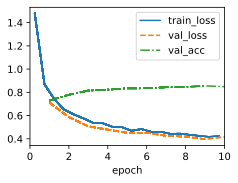

In [ ]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## [**Concise Implementation**]

With high-level APIs, all we need to do is add a `Dropout` layer
after each fully connected layer,
passing in the dropout probability
as the only argument to its constructor.
During training, the `Dropout` layer will randomly
drop out outputs of the previous layer
(or equivalently, the inputs to the subsequent layer)
according to the specified dropout probability.
When not in training mode,
the `Dropout` layer simply passes the data through during testing.


In [ ]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

Next, we [**train the model**].


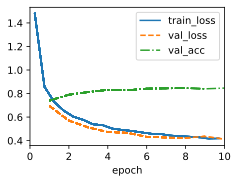

In [ ]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

## Summary

Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool for avoiding overfitting. Often tools are used jointly.
Note that dropout is
used only during training:
it replaces an activation $h$ with a random variable with expected value $h$.


## Exercises

1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.
1. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.
1. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
1. Why is dropout not typically used at test time?
1. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?
1. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?
1. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?


[Discussions](https://discuss.d2l.ai/t/101)


The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

# Predicting House Prices on Kaggle
:label:`sec_kaggle_house`

Now that we have introduced some basic tools
for building and training deep networks
and regularizing them with techniques including
weight decay and dropout,
we are ready to put all this knowledge into practice
by participating in a Kaggle competition.
The house price prediction competition
is a great place to start.
The data is fairly generic and do not exhibit exotic structure
that might require specialized models (as audio or video might).
This dataset, collected by :citet:`De-Cock.2011`,
covers house prices in Ames, Iowa from the period 2006--2010.
It is considerably larger than the famous [Boston housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names) of Harrison and Rubinfeld (1978),
boasting both more examples and more features.


In this section, we will walk you through details of
data preprocessing, model design, and hyperparameter selection.
We hope that through a hands-on approach,
you will gain some intuitions that will guide you
in your career as a data scientist.


In [ ]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## Downloading Data

Throughout the book, we will train and test models
on various downloaded datasets.
Here, we (**implement two utility functions**)
for downloading and extracting zip or tar files.
Again, we skip implementation details of
such utility functions.


In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
that hosts machine learning competitions.
Each competition centers on a dataset and many
are sponsored by stakeholders who offer prizes
to the winning solutions.
The platform helps users to interact
via forums and shared code,
fostering both collaboration and competition.
While leaderboard chasing often spirals out of control,
with researchers focusing myopically on preprocessing steps
rather than asking fundamental questions,
there is also tremendous value in the objectivity of a platform
that facilitates direct quantitative comparisons
among competing approaches as well as code sharing
so that everyone can learn what did and did not work.
If you want to participate in a Kaggle competition,
you will first need to register for an account
(see :numref:`fig_kaggle`).

![The Kaggle website.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle.png?raw=1)
:width:`400px`
:label:`fig_kaggle`

On the house price prediction competition page, as illustrated
in :numref:`fig_house_pricing`,
you can find the dataset (under the "Data" tab),
submit predictions, and see your ranking,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![The house price prediction competition page.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/house-pricing.png?raw=1)
:width:`400px`
:label:`fig_house_pricing`

## Accessing and Reading the Dataset

Note that the competition data is separated
into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features consist of various data types.
For example, the year of construction
is represented by an integer,
the roof type by discrete categorical assignments,
and other features by floating point numbers.
And here is where reality complicates things:
for some examples, some data is altogether missing
with the missing value marked simply as "na".
The price of each house is included
for the training set only
(it is a competition after all).
We will want to partition the training set
to create a validation set,
but we only get to evaluate our models on the official test set
after uploading predictions to Kaggle.
The "Data" tab on the competition tab
in :numref:`fig_house_pricing`
has links for downloading the data.

To get started, we will [**read in and process the data
using `pandas`**], which we introduced in :numref:`sec_pandas`.
For convenience, we can download and cache
the Kaggle housing dataset.
If a file corresponding to this dataset already exists in the cache directory and its SHA-1 matches `sha1_hash`, our code will use the cached file to avoid clogging up your Internet with redundant downloads.


In [ ]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

The training dataset includes 1460 examples,
80 features, and one label, while the validation data
contains 1459 examples and 80 features.


In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


## Data Preprocessing

Let's [**take a look at the first four and final two features
as well as the label (SalePrice)**] from the first four examples.


In [ ]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, the first feature is the identifier.
This helps the model determine each training example.
While this is convenient, it does not carry
any information for prediction purposes.
Hence, we will remove it from the dataset
before feeding the data into the model.
Furthermore, given a wide variety of data types,
we will need to preprocess the data before we can start modeling.


Let's start with the numerical features.
First, we apply a heuristic,
[**replacing all missing values
by the corresponding feature's mean.**]
Then, to put all features on a common scale,
we (***standardize* the data by
rescaling features to zero mean and unit variance**):

$$x \leftarrow \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ denote mean and standard deviation, respectively.
To verify that this indeed transforms
our feature (variable) such that it has zero mean and unit variance,
note that $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
and that $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitively, we standardize the data
for two reasons.
First, it proves convenient for optimization.
Second, because we do not know *a priori*
which features will be relevant,
we do not want to penalize coefficients
assigned to one feature more than any other.

[**Next we deal with discrete values.**]
These include features such as "MSZoning".
(**We replace them by a one-hot encoding**)
in the same way that we earlier transformed
multiclass labels into vectors (see :numref:`subsec_classification-problem`).
For instance, "MSZoning" assumes the values "RL" and "RM".
Dropping the "MSZoning" feature,
two new indicator features
"MSZoning_RL" and "MSZoning_RM" are created with values being either 0 or 1.
According to one-hot encoding,
if the original value of "MSZoning" is "RL",
then "MSZoning_RL" is 1 and "MSZoning_RM" is 0.
The `pandas` package does this automatically for us.


In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

You can see that this conversion increases
the number of features from 79 to 331 (excluding ID and label columns).


In [ ]:
data.preprocess()
data.train.shape

(1460, 331)

## Error Measure

To get started we will train a linear model with squared loss. Not surprisingly, our linear model will not lead to a competition-winning submission but it does provide a sanity check to see whether there is meaningful information in the data. If we cannot do better than random guessing here, then there might be a good chance that we have a data processing bug. And if things work, the linear model will serve as a baseline giving us some intuition about how close the simple model gets to the best reported models, giving us a sense of how much gain we should expect from fancier models.

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus [**we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**]
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by \$100,000
when estimating the price of a house in rural Ohio,
where the value of a typical house is \$125,000,
then we are probably doing a horrible job.
On the other hand, if we err by this amount
in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(there, the median house price exceeds \$4 million).

(**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**)
In fact, this is also the official error measure
used by the competition to evaluate the quality of submissions.
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

## $K$-Fold Cross-Validation

You might recall that we introduced [**cross-validation**]
in :numref:`subsec_generalization-model-selection`, where we discussed how to deal
with model selection.
We will put this to good use to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\textrm{th}$ fold of the data
in a $K$-fold cross-validation procedure.
It proceeds by slicing out the $i^\textrm{th}$ segment
as validation data and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit it here owing to the simplicity of our problem.


In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

[**The average validation error is returned**]
when we train $K$ times in the $K$-fold cross-validation.


In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

## [**Model Selection**]

In this example, we pick an untuned set of hyperparameters
and leave it up to the reader to improve the model.
Finding a good choice can take time,
depending on how many variables one optimizes over.
With a large enough dataset,
and the normal sorts of hyperparameters,
$K$-fold cross-validation tends to be
reasonably resilient against multiple testing.
However, if we try an unreasonably large number of options
we might find that our validation
performance is no longer representative of the true error.


average validation log mse = 0.1802935990691185


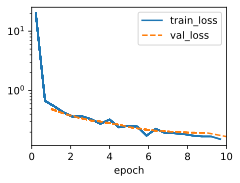

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Notice that sometimes the number of training errors
for a set of hyperparameters can be very low,
even as the number of errors on $K$-fold cross-validation
grows considerably higher.
This indicates that we are overfitting.
Throughout training you will want to monitor both numbers.
Less overfitting might indicate that our data can support a more powerful model.
Massive overfitting might suggest that we can gain
by incorporating regularization techniques.

##  [**Submitting Predictions on Kaggle**]

Now that we know what a good choice of hyperparameters should be,
we might
calculate the average predictions
on the test set
by all the $K$ models.
Saving the predictions in a csv file
will simplify uploading the results to Kaggle.
The following code will generate a file called `submission.csv`.


In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

Next, as demonstrated in :numref:`fig_kaggle_submit2`,
we can submit our predictions on Kaggle
and see how they compare with the actual house prices (labels)
on the test set.
The steps are quite simple:

* Log in to the Kaggle website and visit the house price prediction competition page.
* Click the “Submit Predictions” or “Late Submission” button.
* Click the “Upload Submission File” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.
* Click the “Make Submission” button at the bottom of the page to view your results.

![Submitting data to Kaggle](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/kaggle-submit2.png?raw=1)
:width:`400px`
:label:`fig_kaggle_submit2`

## Summary and Discussion

Real data often contains a mix of different data types and needs to be preprocessed.
Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.
Furthermore, transforming categorical features into indicator features allows us to treat them like one-hot vectors.
When we tend to care more about
the relative error than about the absolute error,
we can
measure the discrepancy in the logarithm of the prediction.
To select the model and adjust the hyperparameters,
we can use $K$-fold cross-validation .



## Exercises

1. Submit your predictions for this section to Kaggle. How good are they?
1. Is it always a good idea to replace missing values by a mean? Hint: can you construct a situation where the values are not missing at random?
1. Improve the score by tuning the hyperparameters through $K$-fold cross-validation.
1. Improve the score by improving the model (e.g., layers, weight decay, and dropout).
1. What happens if we do not standardize the continuous numerical features as we have done in this section?


[Discussions](https://discuss.d2l.ai/t/107)
